Imports and setups

In [2]:
%pip install nibabel matplotlib numpy seaborn scikit-learn tqdm

  Using cached scikit_learn-1.7.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp312-cp312-win_amd64.whl (8.7 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   -- ------------------------------------- 2.6/38.6 MB 21.4 MB/s eta 0:00:02
   ---------- ----------------------------- 10.2/38.6 MB 30.4 MB/s eta 0:00:01
   ---------------- ----------------------- 15.7/38.6 MB 28.3 MB/s eta 0:00:01
   ----------------------- ---------------- 22.3/38.6 MB 29.4 MB/s eta 0:00:01
   ----------------------------- ---------- 28.3/38.6 MB 29.4 MB/s eta 0:00:01
   ------------------------------------ --- 34.9/38.6 MB 29.5 MB/s eta 0:00:01
   ---------------

In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set seaborn style
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

print("✓ All libraries imported successfully")
print(f"NumPy version: {np.__version__}")

✓ All libraries imported successfully
NumPy version: 2.3.4


Configuration & Path Setup

In [4]:
# Paths (relative to notebooks folder)
BASE_PATH = os.path.join('..', 'BraTS2020_training_data', 'MICCAI_BraTS2020_TrainingData')
PATIENT_ID = "BraTS20_Training_001"
PATIENT_PATH = os.path.join(BASE_PATH, PATIENT_ID)

# Output directory for preprocessed data
OUTPUT_DIR = os.path.join('..', 'processed_data')

# Preprocessing parameters
TARGET_SHAPE = (128, 128, 128)  # Cropped volume size
PATCH_SIZE = (64, 64, 64)        # 3D patch dimensions
STRIDE = (32, 32, 32)            # Patch extraction stride
TRAIN_VAL_SPLIT = 0.2            # 80% train, 20% val

# Normalization parameters
PERCENTILE_LOWER = 0.5
PERCENTILE_UPPER = 99.5

# Patch sampling parameters
TUMOR_THRESHOLD = 0.01  # Minimum 1% tumor voxels to consider as tumor patch
BACKGROUND_SAMPLE_RATIO = 0.3  # Keep 30% of background patches

print("="*70)
print("PREPROCESSING CONFIGURATION")
print("="*70)
print(f"Patient ID: {PATIENT_ID}")
print(f"Target Volume Shape: {TARGET_SHAPE}")
print(f"Patch Size: {PATCH_SIZE}")
print(f"Stride: {STRIDE}")
print(f"Train/Val Split: {int((1-TRAIN_VAL_SPLIT)*100)}/{int(TRAIN_VAL_SPLIT*100)}")
print("="*70)

PREPROCESSING CONFIGURATION
Patient ID: BraTS20_Training_001
Target Volume Shape: (128, 128, 128)
Patch Size: (64, 64, 64)
Stride: (32, 32, 32)
Train/Val Split: 80/20


CREATE OUTPUT DIRECTORY STRUCTURE

In [5]:
def create_directory_structure(base_dir):
    """
    Create organized folder structure for preprocessed data.
    """
    directories = [
        os.path.join(base_dir, 'train', 'images'),
        os.path.join(base_dir, 'train', 'masks'),
        os.path.join(base_dir, 'val', 'images'),
        os.path.join(base_dir, 'val', 'masks'),
        os.path.join(base_dir, 'metadata')
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
    
    return directories

# Create directories
created_dirs = create_directory_structure(OUTPUT_DIR)

print("✓ Directory structure created:")
for directory in created_dirs:
    print(f"  • {directory}")
print()

✓ Directory structure created:
  • ..\processed_data\train\images
  • ..\processed_data\train\masks
  • ..\processed_data\val\images
  • ..\processed_data\val\masks
  • ..\processed_data\metadata



LOAD RAW MRI VOLUMES

In [6]:
def load_nifti_volumes(patient_path, patient_id):
    """
    Load all MRI modalities and segmentation mask.
    
    Returns:
        dict: Dictionary containing loaded volumes
    """
    modalities = {
        'flair': os.path.join(patient_path, f"{patient_id}_flair.nii"),
        't1': os.path.join(patient_path, f"{patient_id}_t1.nii"),
        't1ce': os.path.join(patient_path, f"{patient_id}_t1ce.nii"),
        't2': os.path.join(patient_path, f"{patient_id}_t2.nii"),
        'seg': os.path.join(patient_path, f"{patient_id}_seg.nii")
    }
    
    volumes = {}
    
    print("Loading MRI volumes...")
    for modality, file_path in modalities.items():
        if os.path.exists(file_path):
            nifti_obj = nib.load(file_path)
            volumes[modality] = nifti_obj.get_fdata()
            print(f"✓ {modality.upper():6s}: {volumes[modality].shape} | dtype: {volumes[modality].dtype}")
        else:
            print(f"✗ {modality.upper()} not found: {file_path}")
    
    return volumes

# Load volumes
raw_volumes = load_nifti_volumes(PATIENT_PATH, PATIENT_ID)

print(f"\n✓ Loaded {len(raw_volumes)} volumes")

Loading MRI volumes...
✓ FLAIR : (240, 240, 155) | dtype: float64
✓ T1    : (240, 240, 155) | dtype: float64
✓ T1CE  : (240, 240, 155) | dtype: float64
✓ T2    : (240, 240, 155) | dtype: float64
✓ SEG   : (240, 240, 155) | dtype: float64

✓ Loaded 5 volumes


Preprocessing Functions

In [7]:
def convert_to_float32(volume):
    """Convert volume to float32 precision."""
    return volume.astype(np.float32)

def clip_intensity_percentiles(volume, lower=0.5, upper=99.5):
    """
    Clip intensity values to specified percentiles.
    Reduces impact of extreme outliers.
    """
    if np.max(volume) == 0:  # Skip empty volumes
        return volume
    
    lower_bound = np.percentile(volume[volume > 0], lower)
    upper_bound = np.percentile(volume[volume > 0], upper)
    
    volume = np.clip(volume, lower_bound, upper_bound)
    return volume

def zscore_normalize(volume):
    """
    Apply Z-score normalization: (x - mean) / std
    Only normalize non-zero voxels to avoid background interference.
    """
    if np.max(volume) == 0:
        return volume
    
    # Calculate mean and std only from non-zero voxels
    mask = volume > 0
    mean = np.mean(volume[mask])
    std = np.std(volume[mask])
    
    if std > 0:
        volume[mask] = (volume[mask] - mean) / std
    
    # Replace any NaNs with zero
    volume = np.nan_to_num(volume, nan=0.0, posinf=0.0, neginf=0.0)
    
    return volume

def center_crop_or_pad(volume, target_shape):
    """
    Center crop or pad volume to target shape.
    
    Args:
        volume: Input 3D volume
        target_shape: Desired output shape (D, H, W)
    
    Returns:
        Processed volume with target_shape
    """
    current_shape = volume.shape
    
    # Calculate padding/cropping for each dimension
    padded_volume = np.zeros(target_shape, dtype=volume.dtype)
    
    slices = []
    for current, target in zip(current_shape, target_shape):
        if current < target:
            # Need padding
            pad_before = (target - current) // 2
            pad_after = target - current - pad_before
            slices.append((pad_before, pad_before + current))
        else:
            # Need cropping
            crop_before = (current - target) // 2
            slices.append((crop_before, crop_before + target))
    
    # Extract or pad
    if all(c >= t for c, t in zip(current_shape, target_shape)):
        # Pure cropping
        padded_volume = volume[
            slices[0][0]:slices[0][1],
            slices[1][0]:slices[1][1],
            slices[2][0]:slices[2][1]
        ]
    else:
        # Padding involved
        src_slices = []
        for current, target in zip(current_shape, target_shape):
            if current < target:
                src_slices.append(slice(0, current))
            else:
                crop = (current - target) // 2
                src_slices.append(slice(crop, crop + target))
        
        padded_volume[
            slices[0][0]:slices[0][1],
            slices[1][0]:slices[1][1],
            slices[2][0]:slices[2][1]
        ] = volume[src_slices[0], src_slices[1], src_slices[2]]
    
    return padded_volume

def preprocess_volume(volume, is_mask=False):
    """
    Complete preprocessing pipeline for a single volume.
    
    Args:
        volume: Input 3D volume
        is_mask: If True, skip normalization (for segmentation masks)
    
    Returns:
        Preprocessed volume
    """
    # Convert to float32
    volume = convert_to_float32(volume)
    
    if not is_mask:
        # Apply intensity clipping
        volume = clip_intensity_percentiles(volume, PERCENTILE_LOWER, PERCENTILE_UPPER)
        
        # Z-score normalization
        volume = zscore_normalize(volume)
    
    # Center crop or pad to target shape
    volume = center_crop_or_pad(volume, TARGET_SHAPE)
    
    return volume

print("✓ Preprocessing functions defined")
print("  • convert_to_float32")
print("  • clip_intensity_percentiles")
print("  • zscore_normalize")
print("  • center_crop_or_pad")
print("  • preprocess_volume")

✓ Preprocessing functions defined
  • convert_to_float32
  • clip_intensity_percentiles
  • zscore_normalize
  • center_crop_or_pad
  • preprocess_volume


APPLY PREPROCESSING

In [8]:
print("="*70)
print("APPLYING PREPROCESSING PIPELINE")
print("="*70)

preprocessed_volumes = {}

# Process MRI modalities
modality_list = ['flair', 't1', 't1ce', 't2']
for modality in modality_list:
    if modality in raw_volumes:
        print(f"\nProcessing {modality.upper()}...")
        preprocessed_volumes[modality] = preprocess_volume(raw_volumes[modality], is_mask=False)
        
        print(f"  Original shape: {raw_volumes[modality].shape}")
        print(f"  New shape: {preprocessed_volumes[modality].shape}")
        print(f"  Value range: [{preprocessed_volumes[modality].min():.3f}, {preprocessed_volumes[modality].max():.3f}]")
        print(f"  Mean: {preprocessed_volumes[modality].mean():.3f}")
        print(f"  Std: {preprocessed_volumes[modality].std():.3f}")

# Process segmentation mask (no normalization)
if 'seg' in raw_volumes:
    print(f"\nProcessing SEG (mask)...")
    preprocessed_volumes['seg'] = preprocess_volume(raw_volumes['seg'], is_mask=True)
    
    print(f"  Original shape: {raw_volumes['seg'].shape}")
    print(f"  New shape: {preprocessed_volumes['seg'].shape}")
    print(f"  Unique labels: {np.unique(preprocessed_volumes['seg'])}")

print("\n" + "="*70)
print("✓ Preprocessing complete!")
print("="*70)

APPLYING PREPROCESSING PIPELINE

Processing FLAIR...
  Original shape: (240, 240, 155)
  New shape: (128, 128, 128)
  Value range: [-0.371, 6.164]
  Mean: 1.054
  Std: 1.568

Processing T1...
  Original shape: (240, 240, 155)
  New shape: (128, 128, 128)
  Value range: [-0.392, 4.055]
  Mean: 1.057
  Std: 1.452

Processing T1CE...
  Original shape: (240, 240, 155)
  New shape: (128, 128, 128)
  Value range: [-0.389, 6.568]
  Mean: 1.027
  Std: 1.433

Processing T2...
  Original shape: (240, 240, 155)
  New shape: (128, 128, 128)
  Value range: [-0.341, 7.059]
  Mean: 0.994
  Std: 1.658

Processing SEG (mask)...
  Original shape: (240, 240, 155)
  New shape: (128, 128, 128)
  Unique labels: [0. 1. 2. 4.]

✓ Preprocessing complete!


VISUALIZE PREPROCESSED VOLUMES

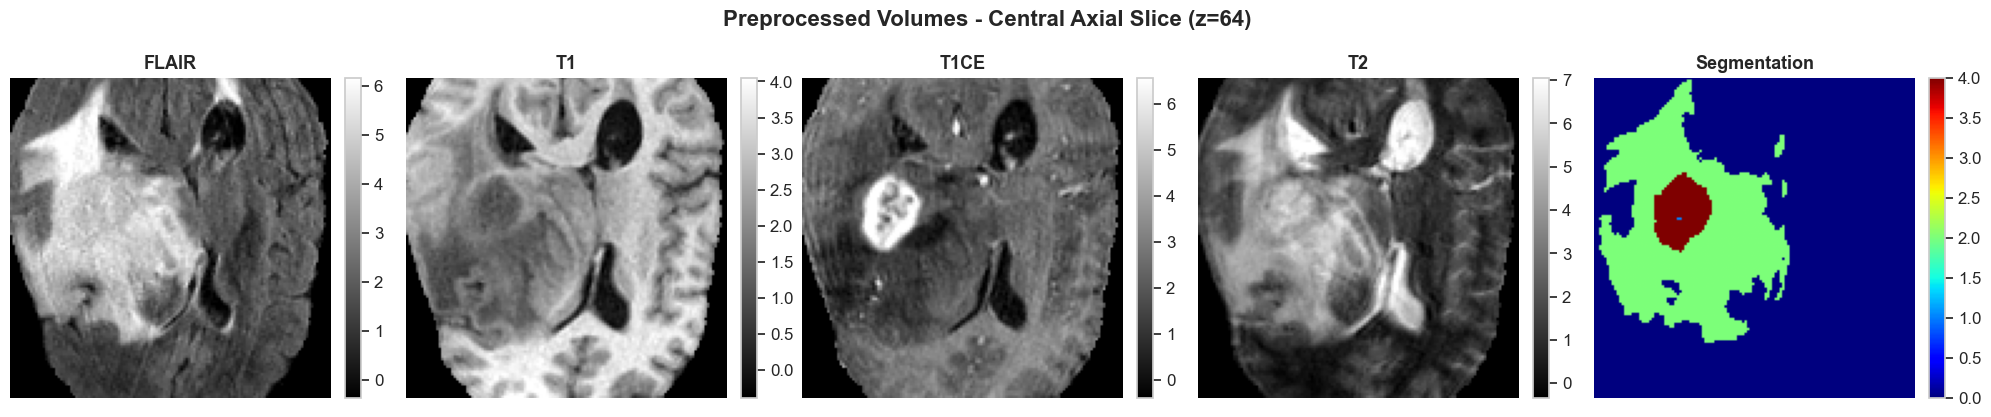

✓ Displayed central slice at z=64
  Preprocessed shape: (128, 128, 128)


In [9]:
# Select middle slice for visualization
mid_slice = TARGET_SHAPE[2] // 2

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle(f'Preprocessed Volumes - Central Axial Slice (z={mid_slice})', 
             fontsize=16, fontweight='bold', y=1.02)

modalities_to_show = ['flair', 't1', 't1ce', 't2', 'seg']
titles = ['FLAIR', 'T1', 'T1CE', 'T2', 'Segmentation']

for idx, (modality, title) in enumerate(zip(modalities_to_show, titles)):
    if modality in preprocessed_volumes:
        ax = axes[idx]
        slice_data = preprocessed_volumes[modality][:, :, mid_slice].T
        
        if modality == 'seg':
            # Use categorical colormap for segmentation
            im = ax.imshow(slice_data, cmap='jet', origin='lower', vmin=0, vmax=4)
        else:
            # Use grayscale for MRI modalities
            im = ax.imshow(slice_data, cmap='gray', origin='lower')
        
        ax.set_title(title, fontsize=13, fontweight='semibold')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"✓ Displayed central slice at z={mid_slice}")
print(f"  Preprocessed shape: {TARGET_SHAPE}")

3D PATCH EXTRACTION UTILITIES

In [10]:
def extract_patches_3d(volume, patch_size, stride):
    """
    Extract 3D patches from a volume using sliding window.
    
    Args:
        volume: Input 3D volume (D, H, W)
        patch_size: Tuple (pd, ph, pw)
        stride: Tuple (sd, sh, sw)
    
    Returns:
        patches: List of extracted patches
        positions: List of (z, y, x) positions for each patch
    """
    d, h, w = volume.shape
    pd, ph, pw = patch_size
    sd, sh, sw = stride
    
    patches = []
    positions = []
    
    for z in range(0, d - pd + 1, sd):
        for y in range(0, h - ph + 1, sh):
            for x in range(0, w - pw + 1, sw):
                patch = volume[z:z+pd, y:y+ph, x:x+pw]
                patches.append(patch)
                positions.append((z, y, x))
    
    return patches, positions

def calculate_tumor_ratio(mask_patch):
    """
    Calculate the ratio of tumor voxels in a patch.
    
    Args:
        mask_patch: Segmentation mask patch
    
    Returns:
        Ratio of non-zero (tumor) voxels
    """
    total_voxels = mask_patch.size
    tumor_voxels = np.count_nonzero(mask_patch)
    return tumor_voxels / total_voxels

def extract_patches_from_volumes(volumes, patch_size, stride, 
                                 tumor_threshold=0.01, 
                                 background_ratio=0.3):
    """
    Extract patches from all modalities with tumor-biased sampling.
    
    Args:
        volumes: Dictionary of preprocessed volumes
        patch_size: Size of patches to extract
        stride: Stride for patch extraction
        tumor_threshold: Minimum tumor ratio to keep patch
        background_ratio: Fraction of background patches to keep
    
    Returns:
        tumor_patches: List of patch dictionaries containing tumor
        background_patches: List of background patch dictionaries
    """
    # Stack modalities into multi-channel volume (C, D, H, W)
    modality_list = ['flair', 't1', 't1ce', 't2']
    stacked_volume = np.stack([volumes[mod] for mod in modality_list], axis=0)
    seg_volume = volumes['seg']
    
    print(f"Extracting patches...")
    print(f"  Multi-modal volume shape: {stacked_volume.shape}")
    print(f"  Patch size: {patch_size}")
    print(f"  Stride: {stride}")
    
    # Extract patches from first modality to get positions
    _, positions = extract_patches_3d(volumes['flair'], patch_size, stride)
    
    print(f"  Total possible patches: {len(positions)}")
    
    tumor_patches = []
    background_patches = []
    
    for idx, (z, y, x) in enumerate(tqdm(positions, desc="Processing patches")):
        pd, ph, pw = patch_size
        
        # Extract patch from all modalities
        image_patch = stacked_volume[:, z:z+pd, y:y+ph, x:x+pw]
        mask_patch = seg_volume[z:z+pd, y:y+ph, x:x+pw]
        
        # Calculate tumor ratio
        tumor_ratio = calculate_tumor_ratio(mask_patch)
        
        patch_dict = {
            'image': image_patch,
            'mask': mask_patch,
            'position': (z, y, x),
            'tumor_ratio': tumor_ratio
        }
        
        if tumor_ratio >= tumor_threshold:
            tumor_patches.append(patch_dict)
        else:
            background_patches.append(patch_dict)
    
    # Sample background patches
    n_background_keep = int(len(background_patches) * background_ratio)
    if n_background_keep < len(background_patches):
        background_indices = np.random.choice(len(background_patches), 
                                             n_background_keep, 
                                             replace=False)
        background_patches = [background_patches[i] for i in background_indices]
    
    print(f"\n✓ Patch extraction complete!")
    print(f"  Tumor patches: {len(tumor_patches)}")
    print(f"  Background patches: {len(background_patches)}")
    print(f"  Total patches: {len(tumor_patches) + len(background_patches)}")
    
    return tumor_patches, background_patches

print("✓ Patch extraction functions defined")

✓ Patch extraction functions defined


EXTRACT PATCHES

In [11]:
print("="*70)
print("EXTRACTING 3D PATCHES")
print("="*70)

tumor_patches, background_patches = extract_patches_from_volumes(
    preprocessed_volumes,
    PATCH_SIZE,
    STRIDE,
    tumor_threshold=TUMOR_THRESHOLD,
    background_ratio=BACKGROUND_SAMPLE_RATIO
)

# Combine all patches
all_patches = tumor_patches + background_patches

# Shuffle patches
np.random.shuffle(all_patches)

print(f"\n{'='*70}")
print("PATCH STATISTICS")
print("="*70)
print(f"Total patches: {len(all_patches)}")
print(f"Tumor patches: {len(tumor_patches)} ({100*len(tumor_patches)/len(all_patches):.1f}%)")
print(f"Background patches: {len(background_patches)} ({100*len(background_patches)/len(all_patches):.1f}%)")
print("="*70)

EXTRACTING 3D PATCHES
Extracting patches...
  Multi-modal volume shape: (4, 128, 128, 128)
  Patch size: (64, 64, 64)
  Stride: (32, 32, 32)
  Total possible patches: 27


Processing patches: 100%|██████████| 27/27 [00:00<00:00, 1210.59it/s]


✓ Patch extraction complete!
  Tumor patches: 26
  Background patches: 0
  Total patches: 26

PATCH STATISTICS
Total patches: 26
Tumor patches: 26 (100.0%)
Background patches: 0 (0.0%)


TRAIN-VALIDATION SPLIT

In [12]:
def stratified_split_patches(patches, val_ratio=0.2):
    """
    Split patches into train and validation sets with stratification.
    Ensures both sets have similar tumor/background distribution.
    
    Args:
        patches: List of patch dictionaries
        val_ratio: Fraction of data for validation
    
    Returns:
        train_patches, val_patches
    """
    # Separate tumor and background patches
    tumor_patches = [p for p in patches if p['tumor_ratio'] >= TUMOR_THRESHOLD]
    background_patches = [p for p in patches if p['tumor_ratio'] < TUMOR_THRESHOLD]
    
    # Split tumor patches
    n_tumor_val = int(len(tumor_patches) * val_ratio)
    tumor_val = tumor_patches[:n_tumor_val]
    tumor_train = tumor_patches[n_tumor_val:]
    
    # Split background patches
    n_bg_val = int(len(background_patches) * val_ratio)
    bg_val = background_patches[:n_bg_val]
    bg_train = background_patches[n_bg_val:]
    
    # Combine and shuffle
    train_patches = tumor_train + bg_train
    val_patches = tumor_val + bg_val
    
    np.random.shuffle(train_patches)
    np.random.shuffle(val_patches)
    
    return train_patches, val_patches

# Perform split
train_patches, val_patches = stratified_split_patches(all_patches, TRAIN_VAL_SPLIT)

print("="*70)
print("TRAIN-VALIDATION SPLIT")
print("="*70)
print(f"Training patches: {len(train_patches)}")
print(f"  Tumor: {sum(1 for p in train_patches if p['tumor_ratio'] >= TUMOR_THRESHOLD)}")
print(f"  Background: {sum(1 for p in train_patches if p['tumor_ratio'] < TUMOR_THRESHOLD)}")
print(f"\nValidation patches: {len(val_patches)}")
print(f"  Tumor: {sum(1 for p in val_patches if p['tumor_ratio'] >= TUMOR_THRESHOLD)}")
print(f"  Background: {sum(1 for p in val_patches if p['tumor_ratio'] < TUMOR_THRESHOLD)}")
print("="*70)

TRAIN-VALIDATION SPLIT
Training patches: 21
  Tumor: 21
  Background: 0

Validation patches: 5
  Tumor: 5
  Background: 0


SAVE PREPROCESSED PATCHES

In [13]:
def save_patches(patches, split_name, output_dir):
    """
    Save patches as .npy files.
    
    Args:
        patches: List of patch dictionaries
        split_name: 'train' or 'val'
        output_dir: Base output directory
    """
    image_dir = os.path.join(output_dir, split_name, 'images')
    mask_dir = os.path.join(output_dir, split_name, 'masks')
    
    print(f"\nSaving {split_name} patches...")
    
    for idx, patch in enumerate(tqdm(patches, desc=f"Saving {split_name}")):
        # Save image (4 channels: FLAIR, T1, T1CE, T2)
        image_path = os.path.join(image_dir, f"patch_{idx:04d}.npy")
        np.save(image_path, patch['image'])
        
        # Save mask
        mask_path = os.path.join(mask_dir, f"patch_{idx:04d}.npy")
        np.save(mask_path, patch['mask'])
    
    print(f"✓ Saved {len(patches)} {split_name} patches")
    print(f"  Images: {image_dir}")
    print(f"  Masks: {mask_dir}")

# Save train patches
save_patches(train_patches, 'train', OUTPUT_DIR)

# Save validation patches
save_patches(val_patches, 'val', OUTPUT_DIR)

print("\n" + "="*70)
print("✓ ALL PATCHES SAVED SUCCESSFULLY")
print("="*70)


Saving train patches...


Saving train: 100%|██████████| 21/21 [00:01<00:00, 19.48it/s]


✓ Saved 21 train patches
  Images: ..\processed_data\train\images
  Masks: ..\processed_data\train\masks

Saving val patches...


Saving val: 100%|██████████| 5/5 [00:00<00:00, 19.53it/s]

✓ Saved 5 val patches
  Images: ..\processed_data\val\images
  Masks: ..\processed_data\val\masks

✓ ALL PATCHES SAVED SUCCESSFULLY


SAVE METADATA

In [14]:
metadata = {
    'patient_id': PATIENT_ID,
    'target_shape': TARGET_SHAPE,
    'patch_size': PATCH_SIZE,
    'stride': STRIDE,
    'train_val_split': TRAIN_VAL_SPLIT,
    'tumor_threshold': TUMOR_THRESHOLD,
    'background_sample_ratio': BACKGROUND_SAMPLE_RATIO,
    'n_train_patches': len(train_patches),
    'n_val_patches': len(val_patches),
    'modalities': ['flair', 't1', 't1ce', 't2'],
    'normalization': 'z-score',
    'percentile_clipping': (PERCENTILE_LOWER, PERCENTILE_UPPER)
}

# Save metadata as numpy file
metadata_path = os.path.join(OUTPUT_DIR, 'metadata', 'preprocessing_config.npy')
np.save(metadata_path, metadata)

print("✓ Metadata saved:")
print(f"  {metadata_path}")
print("\nMetadata contents:")
for key, value in metadata.items():
    print(f"  {key}: {value}")

✓ Metadata saved:
  ..\processed_data\metadata\preprocessing_config.npy

Metadata contents:
  patient_id: BraTS20_Training_001
  target_shape: (128, 128, 128)
  patch_size: (64, 64, 64)
  stride: (32, 32, 32)
  train_val_split: 0.2
  tumor_threshold: 0.01
  background_sample_ratio: 0.3
  n_train_patches: 21
  n_val_patches: 5
  modalities: ['flair', 't1', 't1ce', 't2']
  normalization: z-score
  percentile_clipping: (0.5, 99.5)


ISUALIZE SAMPLE PATCHES

TRAINING SET SAMPLES


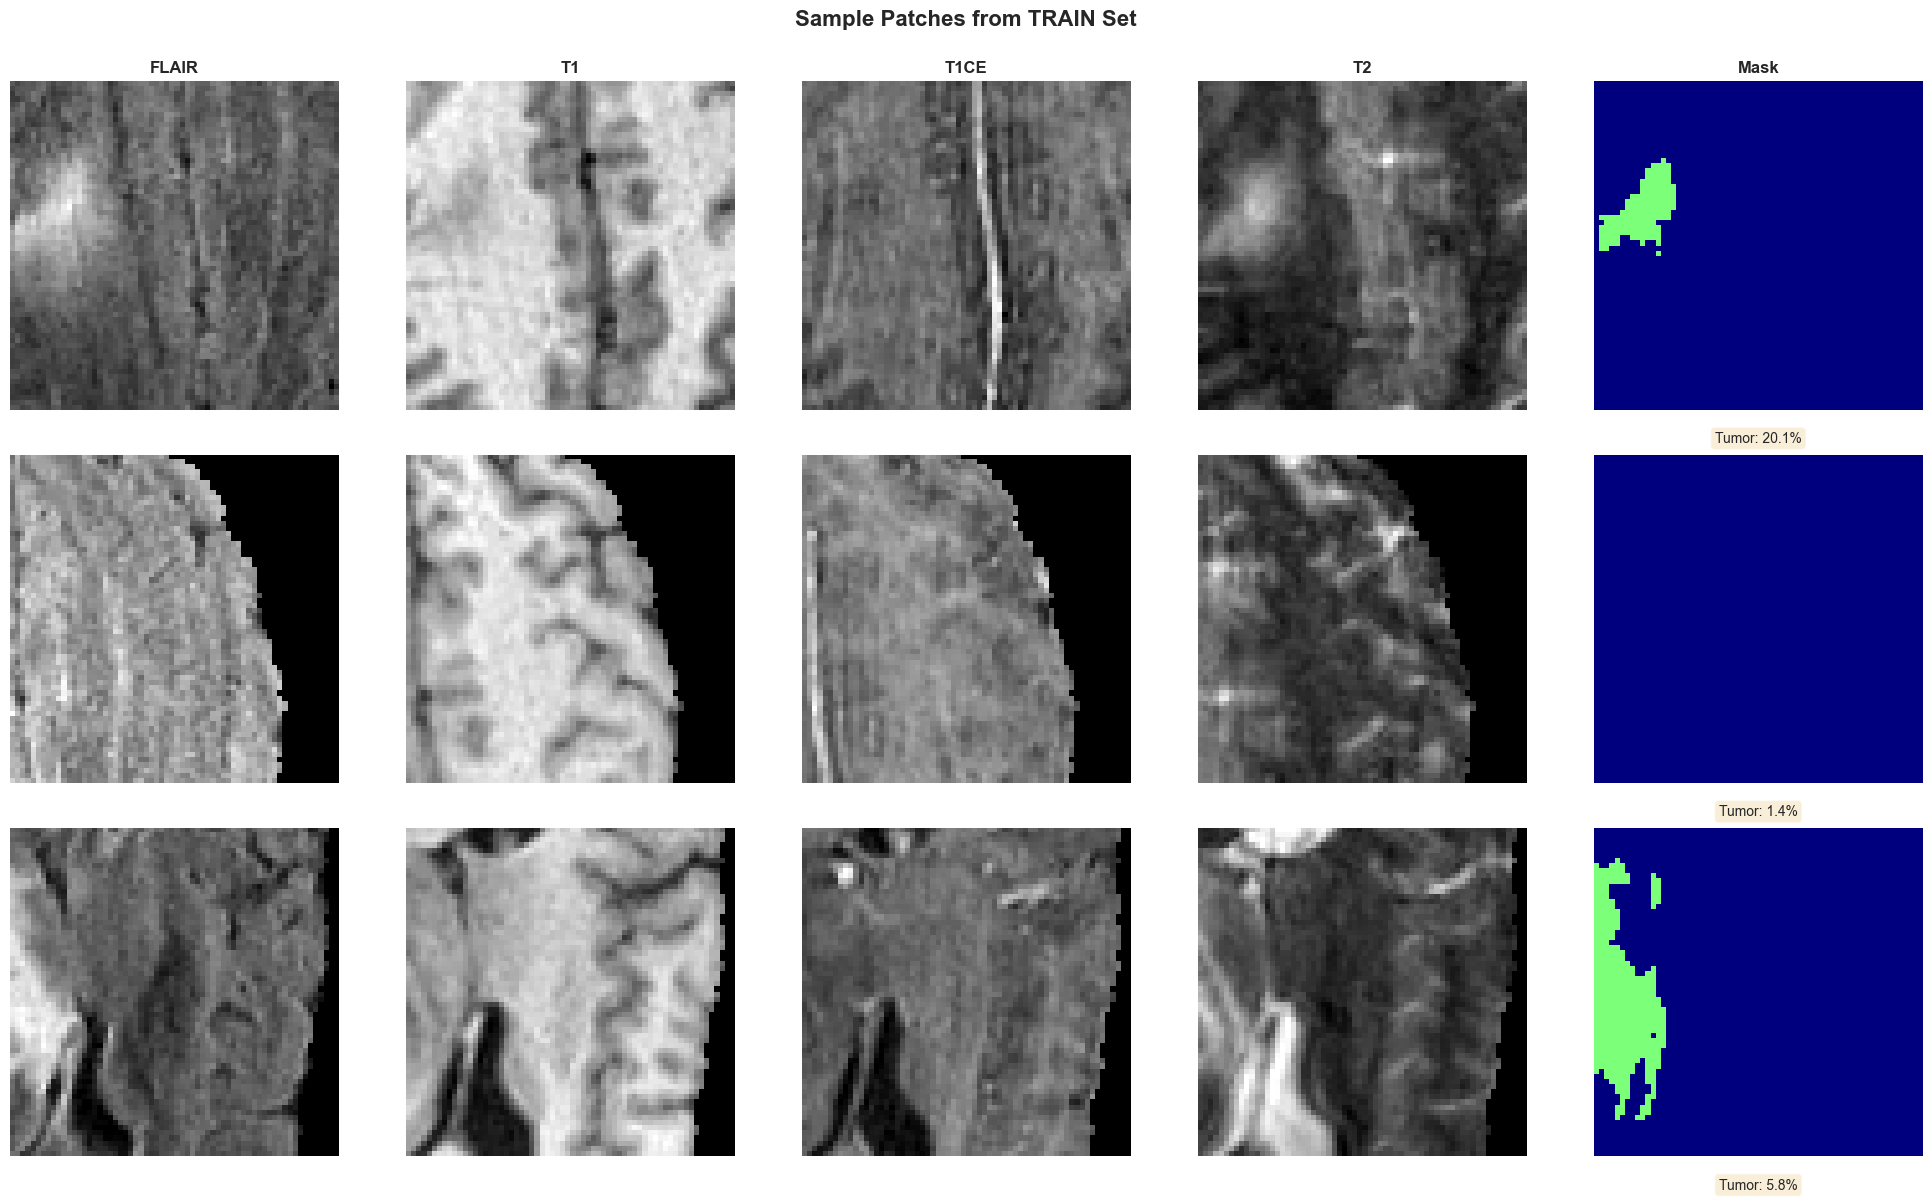


VALIDATION SET SAMPLES


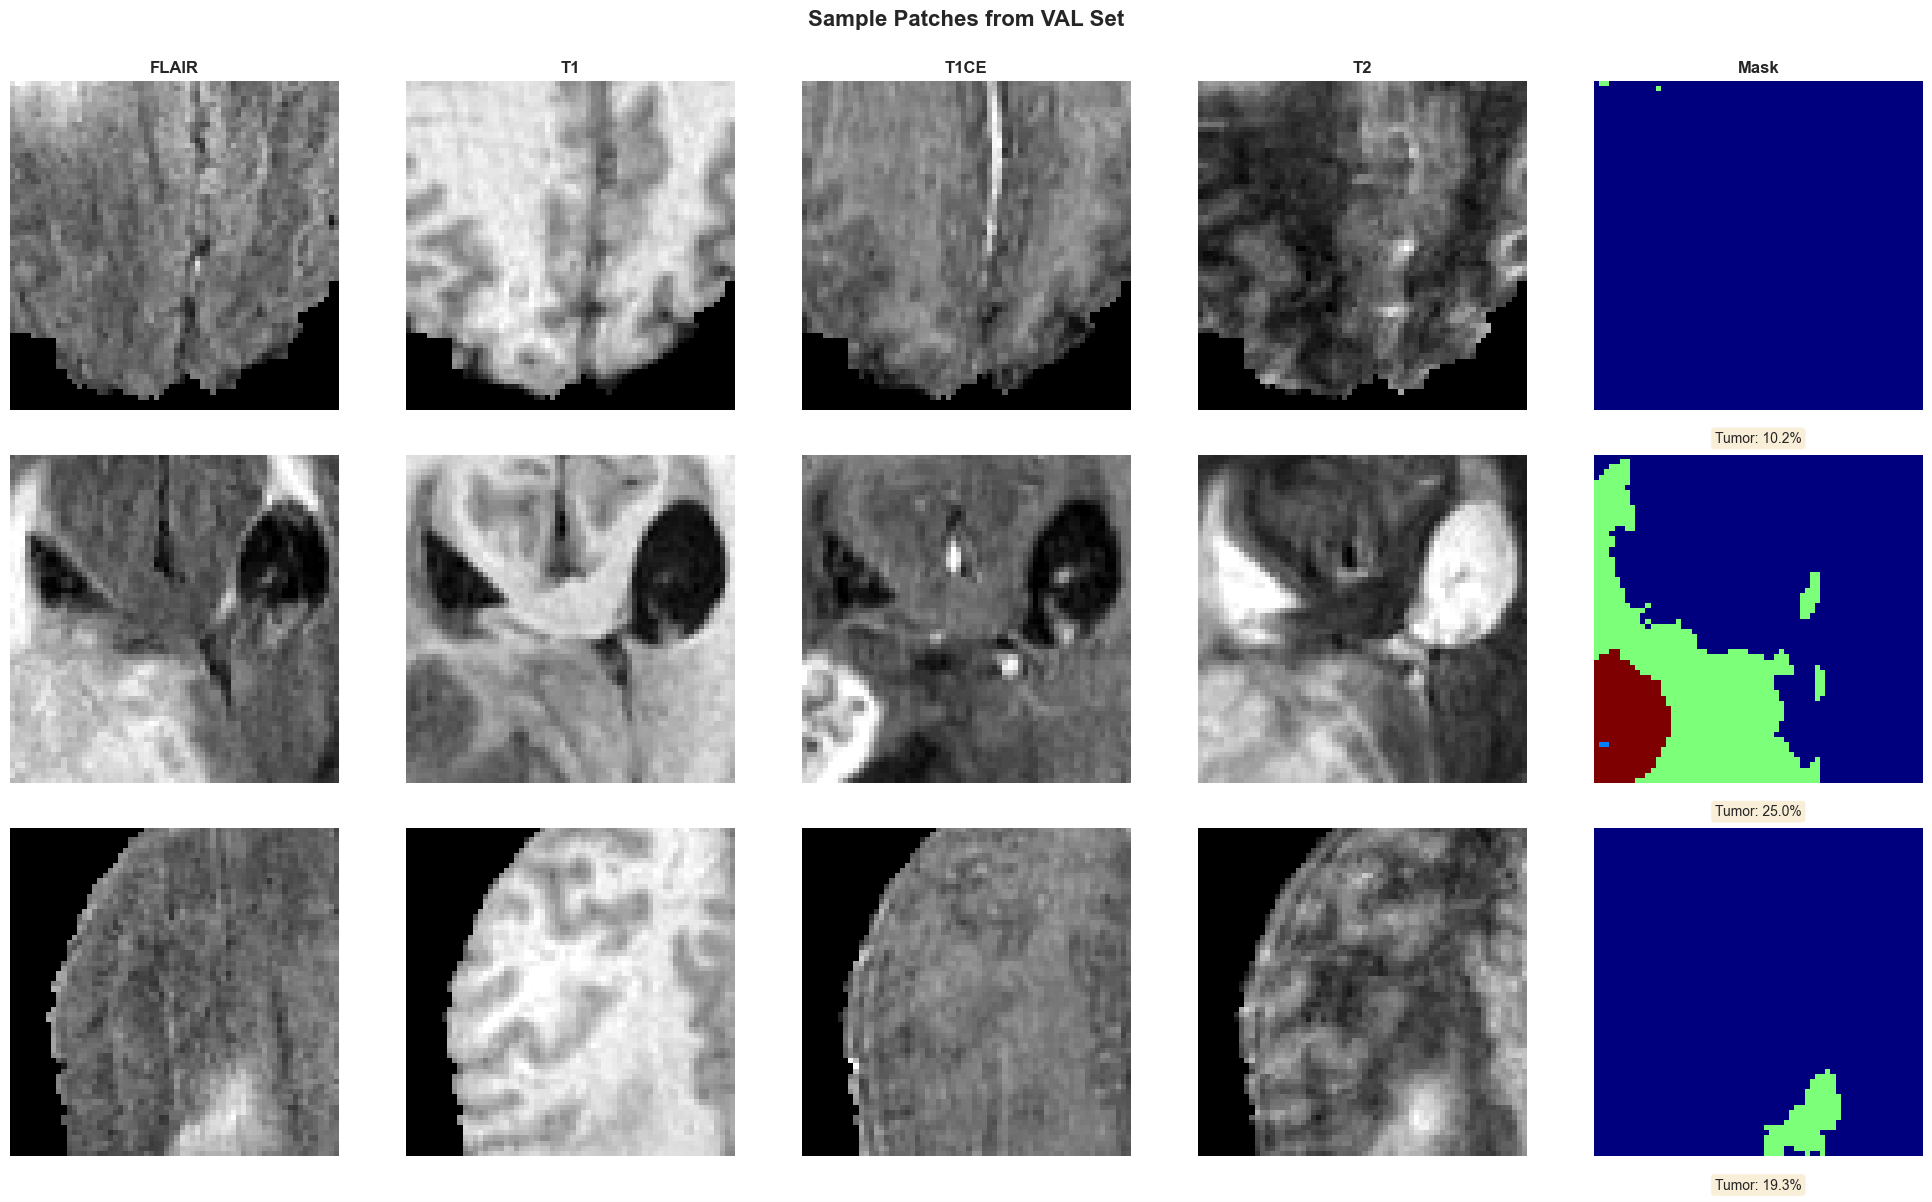

In [15]:
def visualize_sample_patches(patches, n_samples=3, split_name='train'):
    """
    Visualize random patches with mask overlay.
    """
    # Select random patches
    sample_indices = np.random.choice(len(patches), min(n_samples, len(patches)), replace=False)
    
    fig, axes = plt.subplots(n_samples, 5, figsize=(20, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'Sample Patches from {split_name.upper()} Set', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    modality_names = ['FLAIR', 'T1', 'T1CE', 'T2', 'Mask']
    
    for row_idx, patch_idx in enumerate(sample_indices):
        patch = patches[patch_idx]
        image = patch['image']  # Shape: (4, 64, 64, 64)
        mask = patch['mask']    # Shape: (64, 64, 64)
        tumor_ratio = patch['tumor_ratio']
        
        # Get middle slice
        mid_slice = PATCH_SIZE[2] // 2
        
        for col_idx in range(4):
            ax = axes[row_idx, col_idx]
            slice_data = image[col_idx, :, :, mid_slice].T
            
            im = ax.imshow(slice_data, cmap='gray', origin='lower')
            
            if row_idx == 0:
                ax.set_title(modality_names[col_idx], fontsize=12, fontweight='semibold')
            
            ax.axis('off')
        
        # Display mask
        ax = axes[row_idx, 4]
        mask_slice = mask[:, :, mid_slice].T
        im = ax.imshow(mask_slice, cmap='jet', origin='lower', vmin=0, vmax=4)
        
        if row_idx == 0:
            ax.set_title('Mask', fontsize=12, fontweight='semibold')
        
        ax.axis('off')
        
        # Add tumor ratio info
        ax.text(0.5, -0.1, f'Tumor: {tumor_ratio*100:.1f}%', 
               transform=ax.transAxes, 
               ha='center', 
               fontsize=10,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Visualize train patches
print("="*70)
print("TRAINING SET SAMPLES")
print("="*70)
visualize_sample_patches(train_patches, n_samples=3, split_name='train')

# Visualize validation patches
print("\n" + "="*70)
print("VALIDATION SET SAMPLES")
print("="*70)
visualize_sample_patches(val_patches, n_samples=3, split_name='val')

VERIFY SAVED DATA

In [16]:
def verify_saved_patches(output_dir):
    """
    Load and verify a few saved patches.
    """
    print("="*70)
    print("VERIFYING SAVED DATA")
    print("="*70)
    
    for split in ['train', 'val']:
        image_dir = os.path.join(output_dir, split, 'images')
        mask_dir = os.path.join(output_dir, split, 'masks')
        
        # Count files
        n_images = len([f for f in os.listdir(image_dir) if f.endswith('.npy')])
        n_masks = len([f for f in os.listdir(mask_dir) if f.endswith('.npy')])
        
        print(f"\n{split.upper()} Set:")
        print(f"  Images: {n_images}")
        print(f"  Masks: {n_masks}")
        
        # Load first patch to verify
        if n_images > 0:
            sample_image = np.load(os.path.join(image_dir, 'patch_0000.npy'))
            sample_mask = np.load(os.path.join(mask_dir, 'patch_0000.npy'))
            
            print(f"  Sample image shape: {sample_image.shape}")
            print(f"  Sample image dtype: {sample_image.dtype}")
            print(f"  Sample mask shape: {sample_mask.shape}")
            print(f"  Sample mask dtype: {sample_mask.dtype}")
            print(f"  Sample mask labels: {np.unique(sample_mask)}")
    
    print("\n" + "="*70)
    print("✓ DATA VERIFICATION COMPLETE")
    print("="*70)

verify_saved_patches(OUTPUT_DIR)

VERIFYING SAVED DATA

TRAIN Set:
  Images: 21
  Masks: 21
  Sample image shape: (4, 64, 64, 64)
  Sample image dtype: float32
  Sample mask shape: (64, 64, 64)
  Sample mask dtype: float32
  Sample mask labels: [0. 1. 2. 4.]

VAL Set:
  Images: 5
  Masks: 5
  Sample image shape: (4, 64, 64, 64)
  Sample image dtype: float32
  Sample mask shape: (64, 64, 64)
  Sample mask dtype: float32
  Sample mask labels: [0. 2. 4.]

✓ DATA VERIFICATION COMPLETE


SUMMARY

In [17]:
print("\n" + "="*70)
print(" "*20 + "📊 WEEK-2 SUMMARY REPORT")
print("="*70)

print(f"\n{'PREPROCESSING PARAMETERS'}")
print("-"*70)
print(f"  Patient ID: {PATIENT_ID}")
print(f"  Original volume shape: {raw_volumes['flair'].shape}")
print(f"  Preprocessed shape: {TARGET_SHAPE}")
print(f"  Normalization: Z-score (per volume)")
print(f"  Percentile clipping: {PERCENTILE_LOWER}% - {PERCENTILE_UPPER}%")

print(f"\n{'PATCH EXTRACTION'}")
print("-"*70)
print(f"  Patch size: {PATCH_SIZE}")
print(f"  Stride: {STRIDE}")
print(f"  Tumor threshold: {TUMOR_THRESHOLD*100}%")
print(f"  Background sampling ratio: {BACKGROUND_SAMPLE_RATIO*100}%")

print(f"\n{'DATASET STATISTICS'}")
print("-"*70)
print(f"  Total patches: {len(train_patches) + len(val_patches)}")
print(f"  Training patches: {len(train_patches)} ({100*len(train_patches)/(len(train_patches)+len(val_patches)):.1f}%)")
print(f"  Validation patches: {len(val_patches)} ({100*len(val_patches)/(len(train_patches)+len(val_patches)):.1f}%)")

# Calculate tumor ratios
train_tumor = sum(1 for p in train_patches if p['tumor_ratio'] >= TUMOR_THRESHOLD)
val_tumor = sum(1 for p in val_patches if p['tumor_ratio'] >= TUMOR_THRESHOLD)

print(f"\n{'TUMOR VS BACKGROUND'}")
print("-"*70)
print(f"  Train - Tumor: {train_tumor}, Background: {len(train_patches)-train_tumor}")
print(f"  Val - Tumor: {val_tumor}, Background: {len(val_patches)-val_tumor}")

print(f"\n{'OUTPUT DIRECTORY'}")
print("-"*70)
print(f"  Location: {os.path.abspath(OUTPUT_DIR)}")
print(f"  Structure:")
print(f"    ├── train/")
print(f"    │   ├── images/ ({len(train_patches)} patches)")
print(f"    │   └── masks/ ({len(train_patches)} patches)")
print(f"    ├── val/")
print(f"    │   ├── images/ ({len(val_patches)} patches)")
print(f"    │   └── masks/ ({len(val_patches)} patches)")
print(f"    └── metadata/")

print(f"\n{'STORAGE INFORMATION'}")
print("-"*70)
# Estimate storage size
patch_size_bytes = np.prod(PATCH_SIZE) * 4 * 4  # 4 modalities, float32
mask_size_bytes = np.prod(PATCH_SIZE) * 4  # float32
total_size_mb = (len(train_patches) + len(val_patches)) * (patch_size_bytes + mask_size_bytes) / (1024**2)
print(f"  Estimated total size: {total_size_mb:.1f} MB")

print("\n" + "="*70)
print("✅ WEEK-2 PREPROCESSING COMPLETE!")
print("🚀 Ready for Week-3: Model Training (Swin-Transformer-3D)")
print("="*70)


                    📊 WEEK-2 SUMMARY REPORT

PREPROCESSING PARAMETERS
----------------------------------------------------------------------
  Patient ID: BraTS20_Training_001
  Original volume shape: (240, 240, 155)
  Preprocessed shape: (128, 128, 128)
  Normalization: Z-score (per volume)
  Percentile clipping: 0.5% - 99.5%

PATCH EXTRACTION
----------------------------------------------------------------------
  Patch size: (64, 64, 64)
  Stride: (32, 32, 32)
  Tumor threshold: 1.0%
  Background sampling ratio: 30.0%

DATASET STATISTICS
----------------------------------------------------------------------
  Total patches: 26
  Training patches: 21 (80.8%)
  Validation patches: 5 (19.2%)

TUMOR VS BACKGROUND
----------------------------------------------------------------------
  Train - Tumor: 21, Background: 0
  Val - Tumor: 5, Background: 0

OUTPUT DIRECTORY
----------------------------------------------------------------------
  Location: c:\Users\arnav\Desktop\MedBIND3D\MedBI